In [2]:
%config InlineBackend.rc = {"figure.dpi": 72, "figure.figsize": (6.0, 4.0)}
%matplotlib inline

import abtem
from abtem.parametrizations import LobatoParametrization
import ase
import ase.io as io
from ase.visualize import view
from ase.io import read
import matplotlib.pyplot as plt
from ase.io import write

#can create nanoparticle within notebook using ASE, or can be imported from .cfg file, use r' C:/path/to/file
abtem.config.set({"local_diagnostics.progress_bar": False});
atoms = io.read(r'C:\Users\Joshu\Desktop\Models\Ceria.cfg')

In [3]:
view(atoms)
#possible to alter structure of NP from view. 

<Popen: returncode: None args: ['C:\\Users\\Joshu\\anaconda3\\envs\\myenv\\p...>

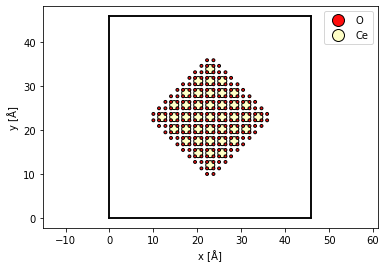

In [4]:
centered_atoms = atoms.copy()
centered_atoms.center()

abtem.show_atoms(
    centered_atoms,
    scale=0.5,
    legend=True,
);

In [5]:
print(f"Simulation cell: {atoms.cell}")

Simulation cell: Cell([45.89498, 45.89498, 45.89498])


In [6]:
#Potential calculated to account for beam interaction with nuclei and electrons of Ceria.

repeated_atoms = atoms * (2, 2, 6)

potential = abtem.Potential(
    repeated_atoms,
    sampling=0.05,
    parametrization="lobato",
    slice_thickness=1,
    projection="finite",
)

In [7]:
len(potential)

276

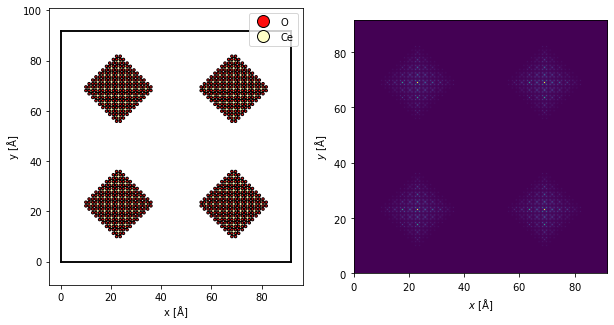

In [8]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

abtem.show_atoms(repeated_atoms, ax=ax1, legend=True)

visualization = potential.show(ax=ax2);

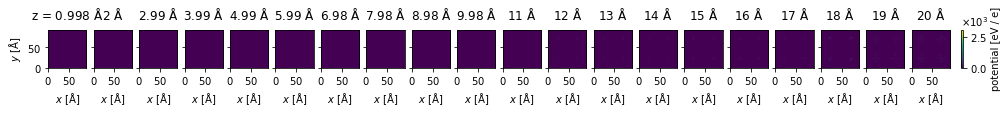

In [9]:
visualization = potential[:20].show(
    project=False,
    explode=True,
    figsize=(16, 5),
    common_color_scale=True,
    cbar=True,
)

#Unsure of visualization purpose.

In [12]:
print(f"Real space sampling: {potential.sampling}")

Real space sampling: (0.04999453159041394, 0.04999453159041394)


In [13]:
probe = abtem.Probe(
    sampling=0.05,
    extent=20,
    energy=200e3,
    semiangle_cutoff=20,
    C10=0,
    Cs=-50e-6 * 1e10,
)

#cs spherical aberration
#c10 defocus
#need to consider adjusting this to match the set-up of our microscope

In [14]:
waves = probe.build()

waves.array
#is this step needed?

dask.array<getitem, shape=(400, 400), dtype=complex64, chunksize=(400, 400), chunktype=numpy.ndarray>

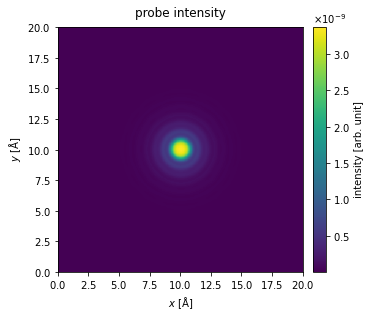

In [15]:
intensity = probe.build().intensity().compute()

visualization = intensity.show(cbar=True)
visualization.set_column_titles("probe intensity", fontsize=12)

In [17]:
sampling = probe.aperture.nyquist_sampling
print(f"Nyquist sampling = {sampling:.3f} Å/pixel")

Nyquist sampling = 0.313 Å/pixel


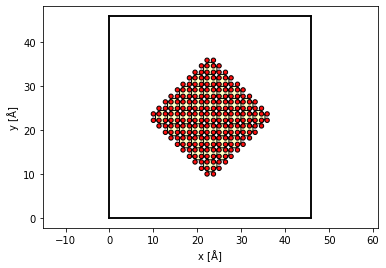

In [18]:
grid_scan = abtem.GridScan(
    start=[1, 0],
    end=[300 /10, 300 / 10],
    sampling=sampling,
    fractional=True,
    potential=potential,
)

fig, ax = abtem.show_atoms(atoms)
grid_scan.add_to_plot(ax)

In [ ]:
pixelated_detector = abtem.PixelatedDetector(max_angle=200)

pixelated_measurements = probe.scan(
    potential,
    scan=grid_scan,
    detectors=pixelated_detector,
)
pixelated_measurements.compute()

In [ ]:
measurements = probe.scan(potential, scan=grid_scan, detectors=all_detectors)

measurements = abtem.stack(measurements, ("BF", "MAADF", "HAADF"))

measurements.to_zarr("mos2_stem_measurements.zarr");